In [1]:
import torch
from torch.utils.data import DataLoader

from levee_hunter.plots import plot_training_validation_loss
from levee_hunter.segmentation_dataset import SegmentationDataset
from levee_hunter.utils import count_parameters
from levee_hunter.plots import infer_and_visualize
from levee_hunter.train_test_split_dataset import train_test_split_dataset
from levee_hunter.modeling.train import train_model
import numpy as np
import segmentation_models_pytorch as smp

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/pmucha/.conda/envs/fathom/lib/python3.11/site-packages/albumentations/core/validation.py:58: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/share/gpu5/pmucha/fathom/levee-hunter/levee_hunter/augmentations.py:17: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(
/share/gpu5/pmucha/fathom/levee-hunter/levee_hunter/augmentations.py:20: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  A.Lambda(
/share/gpu5/pmucha/fathom/levee-hu

In [2]:
# Just a lot of standard code placed in single cell
##################################################
# Load data
train_test_dataset = torch.load(
    "../data/intermediate/1m_512/train_test.pth", weights_only=False
)
validation_dataset = torch.load(
    "../data/intermediate/1m_512/validation.pth", weights_only=False
)
bad_dataset = torch.load(
    "../data/intermediate/1m_512/bad.pth", weights_only=False
)

print(len(train_test_dataset))
print(len(validation_dataset))
print(len(bad_dataset))

##################################################
# Modify targets
train_test_dataset.modify_targets(mask_type='dilated', dilation_size=11)
validation_dataset.modify_targets(mask_type='dilated', dilation_size=11)
bad_dataset.modify_targets(mask_type='dilated', dilation_size=11)

training_dataset, test_dataset = train_test_split_dataset(train_test_dataset, test_size=0.115)

print(len(training_dataset), len(test_dataset))

##################################################
# Data loaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64

train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
val_loader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False)

print(train_loader.dataset.images[0].shape, len(train_loader.dataset.images))

##################################################
# Import Model
model = smp.Segformer(
    encoder_name="mit_b1", encoder_weights="imagenet", in_channels=1, classes=1
).to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-4)

model.load_state_dict(torch.load("../models/w5_models/Segformer-1m_512.pth"))
model.eval()

validation_dataset.transform = 'z_score_normalize'
bad_dataset.transform = 'z_score_normalize'

training_dataset.transform, test_dataset.transform, validation_dataset.transform, bad_dataset.transform

824
196
213
729 95
(1, 512, 512) 729


('train_transform',
 'z_score_normalize',
 'z_score_normalize',
 'z_score_normalize')

In [3]:
from levee_hunter.modeling.infer import infer

for images, masks in test_loader:
    predictions = infer(model, image_tensor=images, device=device, apply_sigmoid=True, threshold=0.5)
predictions.shape

(95, 1, 512, 512)

0


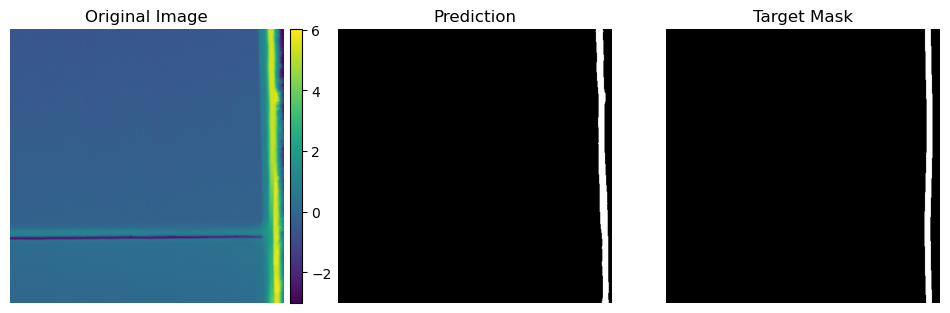

1


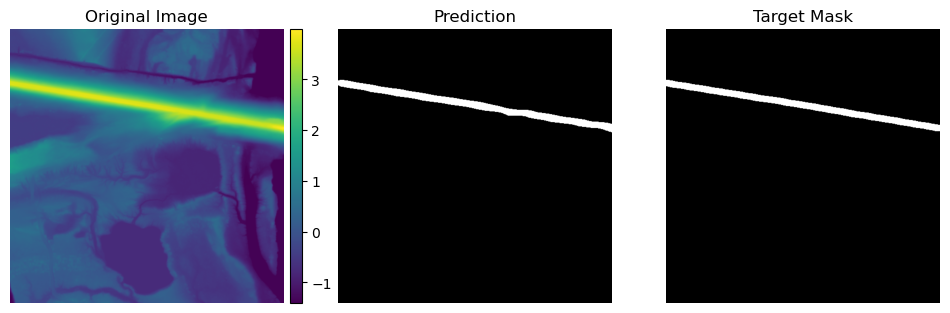

2


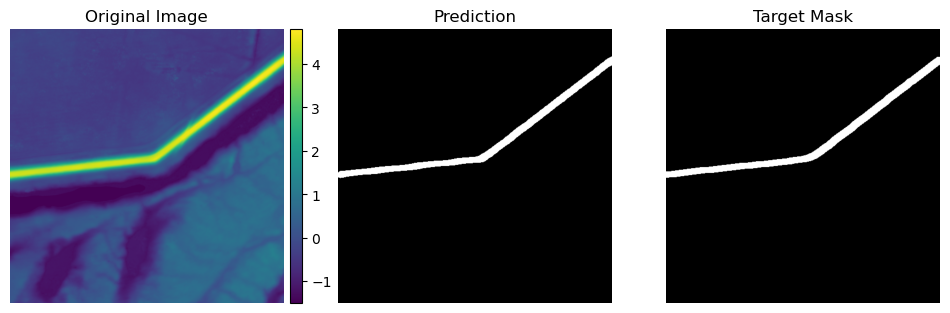

In [4]:
for ix in range(3):
    sample_image, sample_mask = test_dataset[ix]
    print(ix)
    pred = infer_and_visualize(model, sample_image, sample_mask, apply_sigmoid=True, device=device)

0


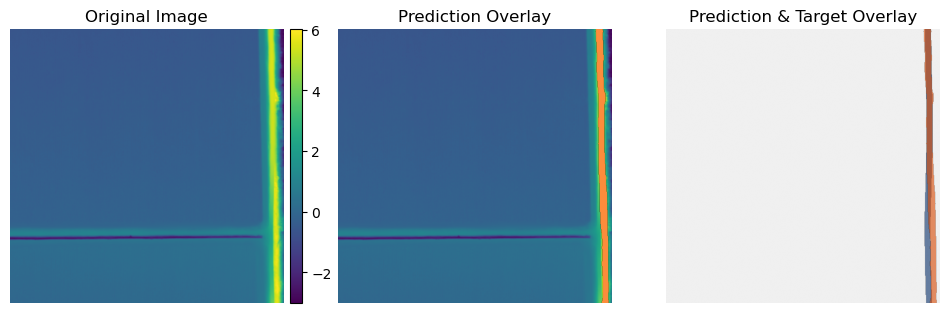

1


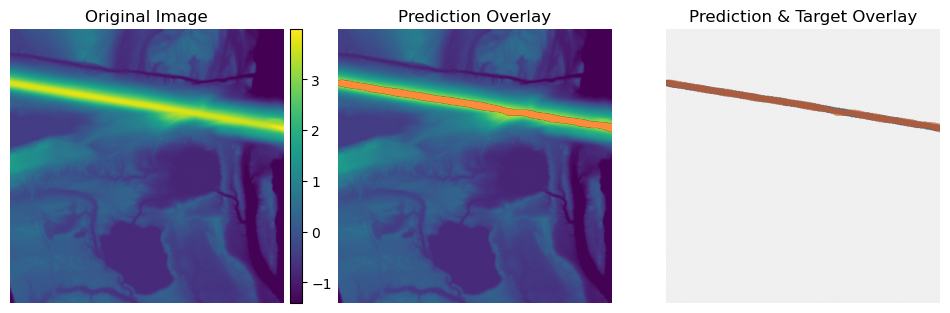

2


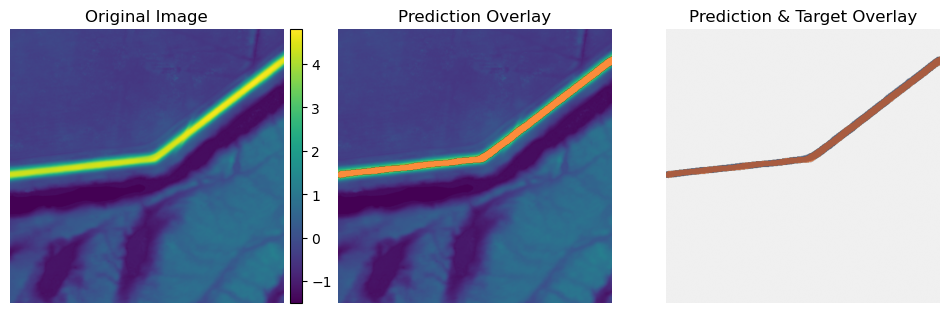

In [5]:
from levee_hunter.plots import infer_and_plot_overlap

for ix in range(3):
    sample_image, sample_mask = test_dataset[ix]
    print(ix)
    pred = infer_and_plot_overlap(
        model=model, 
        image_tensor=sample_image, 
        mask_tensor=sample_mask, 
        device=device, apply_sigmoid=True, 
        threshold=0.5, 
        invert=True
        )

# 1. Standard Metrics

In [6]:
all_preds = []
all_targets = []
threshold = 0.5

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        # Shapes are (batch_size, 1, height, width) for both
        # Note for some loaders batch_size is len(images)
        preds = infer(model, image_tensor=images, device=device, apply_sigmoid=True, threshold=threshold)
        print(preds.shape, masks.shape)

        # Store results for evaluation
        all_preds.append(preds)
        all_targets.append(masks)
        print(all_preds[0].shape, all_targets[0].shape)

# Concatenate all batches into single tensors
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Invert target masks if needed (ensure foreground is 1, background is 0)
all_targets = torch.tensor(1 - all_targets)
all_preds = torch.tensor(1 - all_preds)
# Convert to integer type (0 or 1) to satisfy `get_stats` requirements
all_preds = all_preds.long()
all_targets = all_targets.long()

all_preds.shape, all_targets.shape

(95, 1, 512, 512) torch.Size([95, 1, 512, 512])
(95, 1, 512, 512) torch.Size([95, 1, 512, 512])


(torch.Size([95, 1, 512, 512]), torch.Size([95, 1, 512, 512]))

In [214]:
ix = [1,2,3]
#ix = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

# Compute true positives, false positives, false negatives, true negatives
tp, fp, fn, tn = smp.metrics.get_stats(
    all_preds[ix], all_targets[ix], mode="binary", threshold=threshold
)
#tn = torch.zeros(3,1)
# Compute segmentation metrics
iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
f1_score = smp.metrics.f1_score(tp, fp, fn, tn, reduction="micro")
accuracy = smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
recall = smp.metrics.recall(tp, fp, fn, tn, reduction="micro-imagewise")

# Print Results
print('----------------------Model Evaluation----------------------')
print(f"IoU Score:         {iou_score:.4f}")
print(f"F1 Score (Dice):   {f1_score:.4f}")
print(f"Accuracy:          {accuracy:.4f}")
print(f"Recall:            {recall:.4f}")
print('------------------------------------------------------------')

----------------------Model Evaluation----------------------
IoU Score:         0.9014
F1 Score (Dice):   0.9481
Accuracy:          0.9979
Recall:            0.9603
------------------------------------------------------------


In [192]:
tp.shape

torch.Size([3, 1])

In [208]:
tn

tensor([[255171],
        [254199],
        [259962]])

In [209]:
torch.zeros(3,1)

tensor([[0.],
        [0.],
        [0.]])

# 2. Edge Detection

In [8]:
import cv2


In [9]:
def count_edges(mask: np.ndarray) -> int:
    """
    Counts how many discrete boundary contours are in a binary mask.
    Each connected boundary is treated as one 'edge'.
    """
    # Ensure binary (0/1 or 0/255)
    mask_u8 = (mask > 0).astype(np.uint8)
    
    # Find external contours
    contours, _ = cv2.findContours(
        mask_u8, 
        cv2.RETR_EXTERNAL,     # only outer boundaries
        cv2.CHAIN_APPROX_NONE  # store all boundary pixels
    )
    return len(contours)

In [10]:
def get_pred_mask(all_preds, all_targets, ix):
    pred_mask = np.array(all_preds[ix]).squeeze()
    target_mask = np.array(all_targets[ix]).squeeze()
    return pred_mask, target_mask

In [11]:
i = 4

pred_mask, gt_mask = get_pred_mask(all_preds, all_targets, i)

num_edges_pred = count_edges(pred_mask)
num_edges_gt   = count_edges(gt_mask)

print(f"Prediction edges: {num_edges_pred}, Ground truth edges: {num_edges_gt}")

Prediction edges: 2, Ground truth edges: 2


In [12]:
def plot_contours(pred_mask, gt_mask):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Prepare predicted mask contours
    pred_u8 = (pred_mask > 0).astype(np.uint8)
    contours_pred, _ = cv2.findContours(pred_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Prepare ground truth mask contours
    gt_u8 = (gt_mask > 0).astype(np.uint8)
    contours_gt, _ = cv2.findContours(gt_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # Create side-by-side subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot predicted mask and its contours
    axs[0].imshow(pred_mask, cmap='gray')
    axs[0].set_title("Predicted Mask + Edges")
    for c in contours_pred:
        c = c.squeeze(axis=1)
        axs[0].plot(c[:, 0], c[:, 1])
    
    # Plot ground truth mask and its contours
    axs[1].imshow(gt_mask, cmap='gray')
    axs[1].set_title("Ground Truth Mask + Edges")
    for c in contours_gt:
        c = c.squeeze(axis=1)
        axs[1].plot(c[:, 0], c[:, 1])
    
    plt.show()

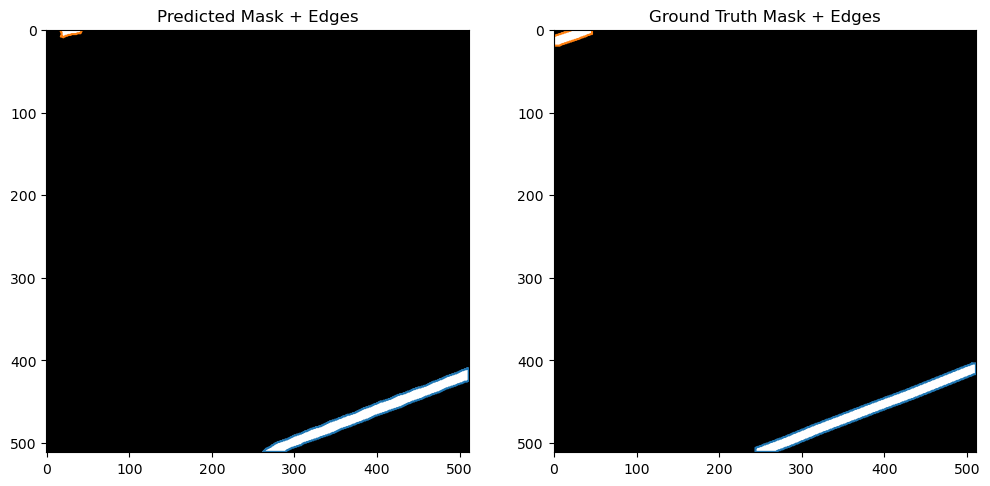

In [13]:
plot_contours(pred_mask, gt_mask)

# 3. Skeleton Stuff

In [14]:
from skimage.morphology import skeletonize

In [15]:
def get_skeleton(binary_mask: np.ndarray, labeled: bool = False) -> np.ndarray:
    """
    Returns a binary skeleton from a binary mask (0=background, 1=foreground).
    
    If labeled is True, returns a labeled skeleton where each connected component
    is assigned a unique label (background=0, components>=1). The default (labeled=False)
    returns a binary skeleton mask.
    
    Parameters:
        binary_mask (np.ndarray): Input binary mask.
        labeled (bool): Whether to return labeled components. Default is False.
    
    Returns:
        np.ndarray: Binary skeleton or labeled skeleton.
    """
    # Ensure boolean input for skeletonize
    bool_mask = (binary_mask > 0)
    skel = skeletonize(bool_mask)
    skel_binary = skel.astype(np.uint8)
    
    if labeled:
        # Label connected components: background is 0, others are 1,2,...
        num_labels, labels = cv2.connectedComponents(skel_binary)
        return labels
    else:
        return skel_binary

In [16]:
# Example: pick an image index
i = 4
pred_mask, gt_mask = get_pred_mask(all_preds, all_targets, i)

# Compute skeletons
skel_pred = get_skeleton(pred_mask, labeled=False)
skel_gt   = get_skeleton(gt_mask, labeled=False)

In [17]:
skel_gt

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [18]:
np.max(skel_gt)

1

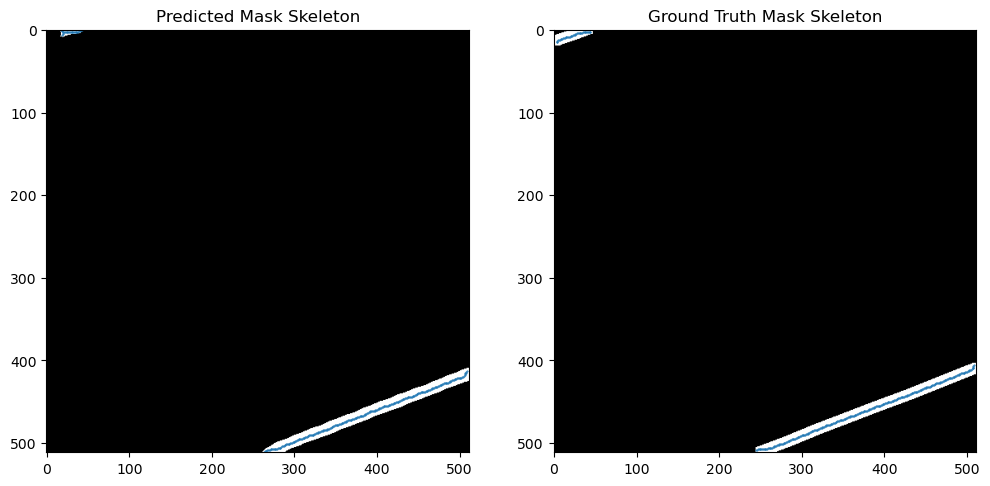

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Predicted Mask Skeleton
axs[0].imshow(pred_mask, cmap="gray")
axs[0].set_title("Predicted Mask Skeleton")
ys_pred, xs_pred = np.where(skel_pred == 1)
axs[0].scatter(xs_pred, ys_pred, marker='.', s=1)

# Plot Ground Truth Mask Skeleton
axs[1].imshow(gt_mask, cmap="gray")
axs[1].set_title("Ground Truth Mask Skeleton")
ys_gt, xs_gt = np.where(skel_gt == 1)
axs[1].scatter(xs_gt, ys_gt, marker='.', s=1)

plt.show()

In [20]:
pred_mask, gt_mask = get_pred_mask(all_preds, all_targets, 6)

In [21]:
skel_pred = get_skeleton(pred_mask, labeled=True)
skel_gt   = get_skeleton(gt_mask, labeled=True)

skel_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [22]:
np.max(skel_pred), np.max(skel_gt)

(5, 2)

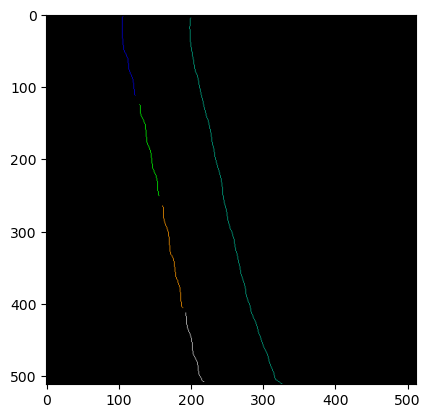

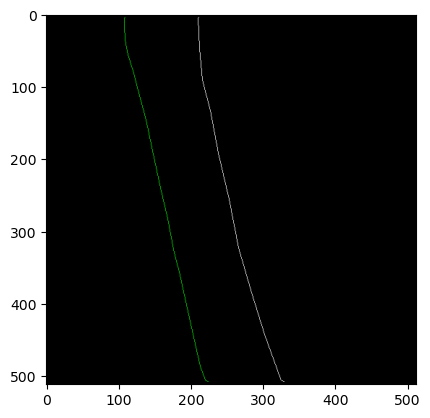

In [23]:
plt.imshow(skel_pred, cmap='nipy_spectral')
plt.show()
plt.imshow(skel_gt, cmap='nipy_spectral')
plt.show()

In [24]:
def find_endpoints(skel: np.ndarray):
    """
    Find endpoints in a skeleton. An endpoint is defined as a skeleton pixel
    with exactly 1 neighbor in 8 directions.
    
    Returns: list of (y, x)
    """
    # Label connected components first
    num_labels, labels = cv2.connectedComponents(skel.astype(np.uint8))
    
    endpoints = []
    for lbl in range(1, num_labels):  # label=0 is background
        component_mask = (labels == lbl)
        ys, xs = np.where(component_mask)
        
        for (y, x) in zip(ys, xs):
            nbrs = 0
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    if dy == 0 and dx == 0:
                        continue
                    ny, nx = y+dy, x+dx
                    if 0 <= ny < skel.shape[0] and 0 <= nx < skel.shape[1]:
                        if component_mask[ny, nx]:
                            nbrs += 1
            if nbrs == 1:
                endpoints.append((y, x))
    
    return endpoints

skel_pred = get_skeleton(pred_mask)
find_endpoints(skel_pred)

[(3, 106),
 (112, 123),
 (5, 200),
 (511, 326),
 (125, 129),
 (251, 156),
 (265, 161),
 (406, 189),
 (413, 193),
 (508, 218)]

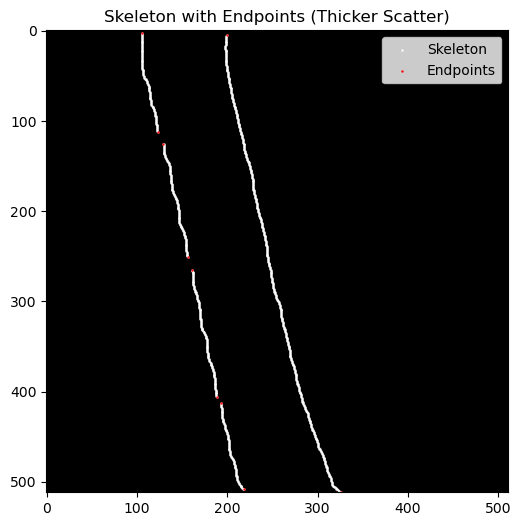

In [50]:
def visualize_skeleton_and_endpoints(
    skel: np.ndarray, 
    endpoints, 
    skeleton_marker_size: int = 5,
    endpoint_marker_size: int = 20,
    gt_skel: np.ndarray = None,
):
    """
    Visualize the skeleton (via scatter points) and overlay endpoint pixels in red.

    Parameters
    ----------
    skel : np.ndarray
        2D array (H, W) with 0/1 indicating skeleton pixels.
    endpoints : list/array
        A list of endpoint tuples, e.g. [(y, x), ...] or [(y, x, label), ...].
        If the label is present, it is simply ignored here.
    skeleton_marker_size : int
        Marker size for plotting each skeleton pixel.
    endpoint_marker_size : int
        Marker size for plotting each endpoint.
    """
    plt.figure(figsize=(6, 6))
    plt.title("Skeleton with Endpoints (Thicker Scatter)")

    if gt_skel is not None:
        # Get ground truth skeleton pixels
        gt_ys, gt_xs = np.where(gt_skel == 1)
        plt.scatter(gt_xs, gt_ys, c='cyan', s=skeleton_marker_size, label='GT Skeleton')
    
    # Show a blank background (black) for clarity
    # Alternatively, could do plt.imshow(skel, cmap='gray') if you like
    plt.imshow(np.zeros_like(skel), cmap='gray', interpolation='none')
    
    # Scatter-plot all skeleton pixels in white
    skel_ys, skel_xs = np.where(skel == 1)
    plt.scatter(skel_xs, skel_ys, c='white', s=skeleton_marker_size, label='Skeleton')
    
    # Extract endpoint coords from the list (some might have label or direction)
    end_ys = []
    end_xs = []
    for e in endpoints:
        # If endpoint is (y, x)
        if len(e) == 2:
            y, x = e
        # If endpoint is (y, x, label) or (y, x, label, direction)
        else:
            y, x = e[0], e[1]
        end_ys.append(y)
        end_xs.append(x)
    
    # Plot endpoints in red, a bit larger
    plt.scatter(end_xs, end_ys, c='red', s=endpoint_marker_size, label='Endpoints')
    
    plt.legend()
    plt.show()

visualize_skeleton_and_endpoints(skel_pred, find_endpoints(skel_pred), endpoint_marker_size=0.5, skeleton_marker_size=0.5)

In [51]:
from skimage.draw import line as skimage_line

def connect_close_endpoints_simple(skel: np.ndarray, dist_thresh=20) -> np.ndarray:
    """
    Connects any two endpoints across different connected components 
    if their distance is below 'dist_thresh'.
    
    skel: 2D skeleton (0 or 1)
    dist_thresh: max pixel distance to consider endpoints "close"
    
    Returns: Updated skeleton with lines added.
    """
    # Compute connected components and their labels
    num_labels, labels = cv2.connectedComponents(skel.astype(np.uint8))
    
    # Get endpoints from the skeleton (list of (y, x))
    endpoints = find_endpoints(skel)
    
    # Attach the label to each endpoint
    endpoints_with_labels = [(y, x, labels[y, x]) for (y, x) in endpoints]
    
    # Compare each pair of endpoints from different components
    for i in range(len(endpoints_with_labels)):
        y1, x1, lbl1 = endpoints_with_labels[i]
        for j in range(i + 1, len(endpoints_with_labels)):
            y2, x2, lbl2 = endpoints_with_labels[j]
            if lbl1 == lbl2:
                continue  # Skip endpoints in the same component
            dist = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
            if dist <= dist_thresh:
                rr, cc = skimage_line(int(y1), int(x1), int(y2), int(x2))
                skel[rr, cc] = 1
    return skel

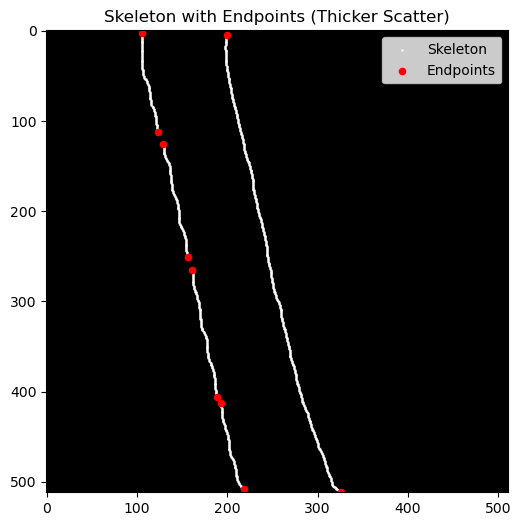

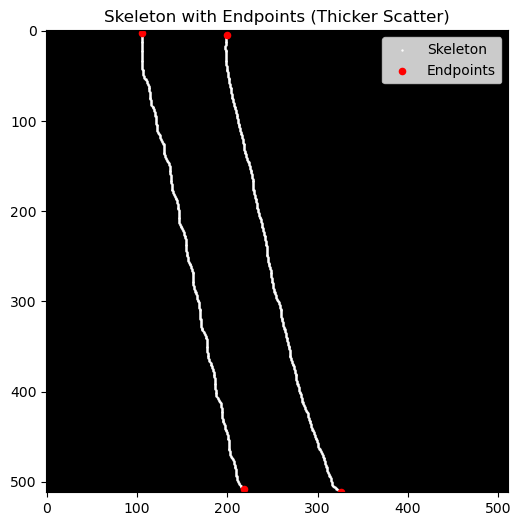

In [52]:
i = 6
pred_mask = np.array(all_preds[i]).squeeze()  # your predicted 2D mask

# 1. Skeletonize
skel_pred = get_skeleton(pred_mask)

# 2. Visualize initial skeleton
endpoints_pred = find_endpoints(skel_pred)
visualize_skeleton_and_endpoints(skel_pred, endpoints_pred, skeleton_marker_size=0.5)

# 3. Connect close endpoints
skel_merged = connect_close_endpoints_simple(skel_pred.copy(), dist_thresh=20)

# 4. Visualize result
endpoints_merged = find_endpoints(skel_merged)
visualize_skeleton_and_endpoints(skel_merged, endpoints_merged, skeleton_marker_size=0.5)

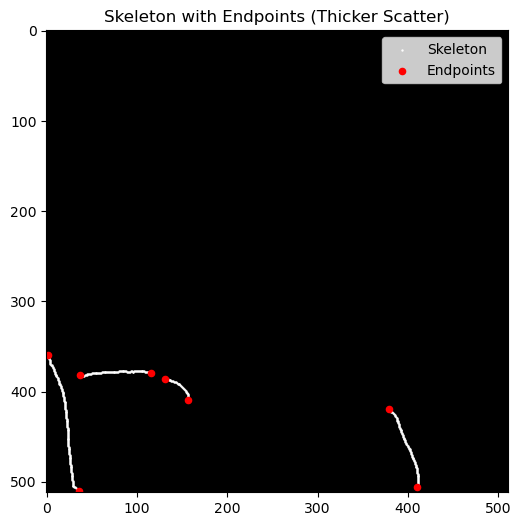

In [53]:
i = 5
pred_mask = np.array(all_preds[i]).squeeze()  # your predicted 2D mask
gt_mask = np.array(all_targets[i]).squeeze()  # your ground truth 2D mask

# 1. Skeletonize
skel_pred = get_skeleton(pred_mask, labeled=False)
skel_gt = get_skeleton(gt_mask, labeled=False)

# 2. Visualize initial skeleton
endpoints_pred = find_endpoints(skel_pred)
visualize_skeleton_and_endpoints(skel_pred, endpoints_pred, skeleton_marker_size=0.5)

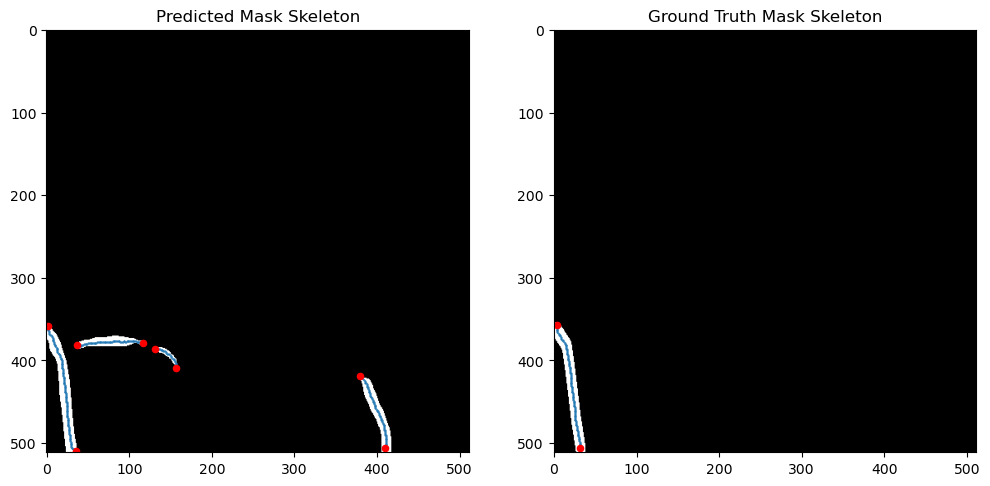

In [54]:
pred_end = find_endpoints(skel_pred)
gt_end = find_endpoints(skel_gt)

# Extract endpoint coords from the list (some might have label or direction)
pred_end_ys = []
pred_end_xs = []
for e in pred_end:
    # If endpoint is (y, x)
    if len(e) == 2:
        y, x = e
    # If endpoint is (y, x, label) or (y, x, label, direction)
    else:
        y, x = e[0], e[1]
    pred_end_ys.append(y)
    pred_end_xs.append(x)

gt_end_ys = []
gt_end_xs = []
for e in gt_end:
    # If endpoint is (y, x)
    if len(e) == 2:
        y, x = e
    # If endpoint is (y, x, label) or (y, x, label, direction)
    else:
        y, x = e[0], e[1]
    gt_end_ys.append(y)
    gt_end_xs.append(x)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot Predicted Mask Skeleton
axs[0].imshow(pred_mask, cmap="gray")
axs[0].set_title("Predicted Mask Skeleton")
ys_pred, xs_pred = np.where(skel_pred == 1)
axs[0].scatter(xs_pred, ys_pred, marker='.', s=1)

axs[0].scatter(pred_end_xs, pred_end_ys, marker='o', color='red', s=20)

# Plot Ground Truth Mask Skeleton
axs[1].imshow(gt_mask, cmap="gray")
axs[1].set_title("Ground Truth Mask Skeleton")
ys_gt, xs_gt = np.where(skel_gt == 1)
axs[1].scatter(xs_gt, ys_gt, marker='.', s=1)
axs[1].scatter(gt_end_xs, gt_end_ys, marker='o', color='red', s=20)

plt.show()

In [55]:
len(ys_gt)

150

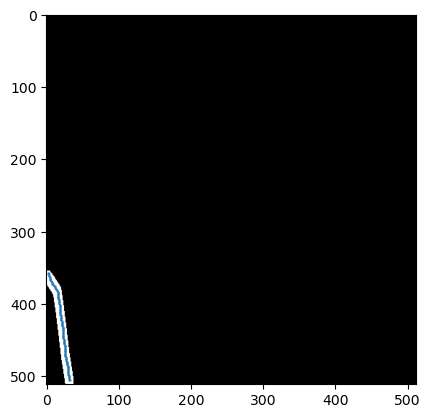

In [56]:
plt.imshow(gt_mask, cmap="gray")
plt.scatter(xs_gt, ys_gt, marker='.', s=1)

In [57]:
len(xs_pred)

356

In [58]:
from scipy.ndimage import distance_transform_edt

def count_pred_pixels_within_distance(pred_skel: np.ndarray, gt_skel: np.ndarray, d: float) -> int:
    """
    Returns how many predicted skeleton pixels are within distance 'd'
    of any ground-truth skeleton pixel.

    pred_skel, gt_skel: 2D arrays (0 or 1)
    d: distance threshold
    """
    # Distance transform of the *complement* of the ground-truth skeleton.
    # dist_map[y, x] will be the distance from (y, x) to the nearest gt_skel==1 pixel.
    dist_map = distance_transform_edt(1 - gt_skel)
    
    # Extract pixel coordinates where pred_skel==1
    ys_pred, xs_pred = np.where(pred_skel == 1)
    
    # Count how many predicted pixels are within distance d
    within_distance = np.sum(dist_map[ys_pred, xs_pred] <= d)
    return within_distance

# Example usage:
fp_count = count_pred_pixels_within_distance(skel_pred, skel_gt, d=8)
print("Number of pred_skel pixels within distance 5:", fp_count)

Number of pred_skel pixels within distance 5: 154


In [59]:
def count_tp_fp(pred_skel, gt_skel, d):
    """
    Returns (tp_count, fp_count) based on distance threshold d:
      TP = # of pred_skel pixels within distance d to any gt_skel pixel
      FP = # of pred_skel pixels - TP
    """
    total_pred = pred_skel.sum()
    tp_count = count_pred_pixels_within_distance(pred_skel, gt_skel, d)
    fp_count = total_pred - tp_count
    return tp_count, fp_count

tp, fp = count_tp_fp(skel_pred, skel_gt, d=8)
print(f"TP = {tp}, FP = {fp}")

TP = 154, FP = 202.0


In [60]:
def count_fn(gt_skel: np.ndarray, pred_skel: np.ndarray, d: float) -> int:
    """
    Returns the number of ground truth skeleton pixels (FN) that are not
    within distance d of any predicted skeleton pixel.
    
    Parameters:
        gt_skel: Ground truth skeleton (2D array, 0 or 1).
        pred_skel: Predicted skeleton (2D array, 0 or 1).
        d: Distance threshold.
        
    Returns:
        int: Count of false negative pixels.
    """
    # Compute the distance transform of the complement of the predicted skeleton.
    # For each pixel, this gives the distance to the nearest pred_skel==1 pixel.
    dist_map_pred = distance_transform_edt(1 - pred_skel)
    
    # Get the coordinates of the ground truth skeleton pixels.
    ys_gt, xs_gt = np.where(gt_skel == 1)
    
    # Count how many ground truth pixels are farther than d from any predicted pixel.
    fn_count = np.sum(dist_map_pred[ys_gt, xs_gt] > d)
    return fn_count

# Example usage:
for d in [1, 2, 7, 8, 9]:
    fn = count_fn(skel_gt, skel_pred, d)
    print(f"Distance threshold: {d}, FN (gt pixels not matched) count: {fn}")

Distance threshold: 1, FN (gt pixels not matched) count: 46
Distance threshold: 2, FN (gt pixels not matched) count: 17
Distance threshold: 7, FN (gt pixels not matched) count: 0
Distance threshold: 8, FN (gt pixels not matched) count: 0
Distance threshold: 9, FN (gt pixels not matched) count: 0


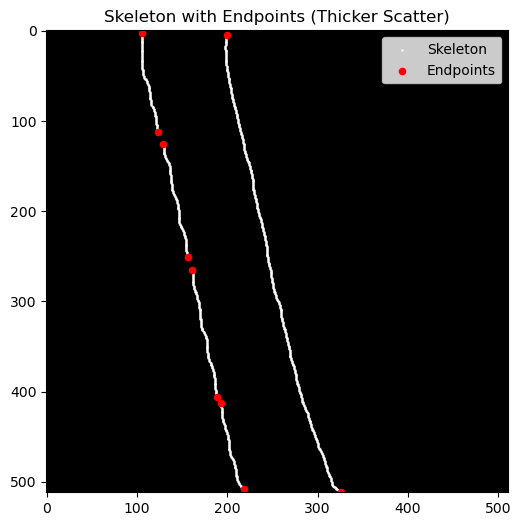

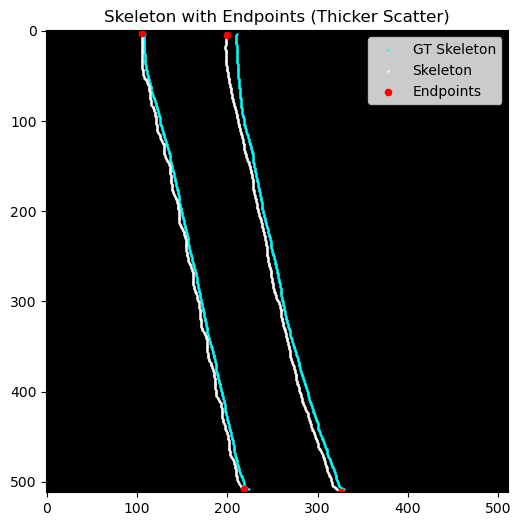

In [65]:
i = 6
pred_mask = np.array(all_preds[i]).squeeze()  # your predicted 2D mask
gt_mask = np.array(all_targets[i]).squeeze()  # your ground truth

# 1. Skeletonize
skel_pred = get_skeleton(pred_mask)
skel_gt = get_skeleton(gt_mask)

# 2. Visualize initial skeleton
endpoints_pred = find_endpoints(skel_pred)
visualize_skeleton_and_endpoints(skel_pred, endpoints_pred, skeleton_marker_size=0.5)

# 3. Connect close endpoints
skel_merged = connect_close_endpoints_simple(skel_pred.copy(), dist_thresh=20)

# 4. Visualize result
endpoints_merged = find_endpoints(skel_merged)
visualize_skeleton_and_endpoints(skel_merged, endpoints_merged, skeleton_marker_size=0.5, gt_skel=skel_gt)

In [62]:
tp, fp = count_tp_fp(pred_skel=skel_pred, gt_skel=skel_gt, d=13)
print(f"TP = {tp}, FP = {fp}")

TP = 0, FP = 986.0


In [63]:
tp, fp = count_tp_fp(pred_skel=skel_merged, gt_skel=skel_gt, d=13)
print(f"TP = {tp}, FP = {fp}")

TP = 0, FP = 1017.0


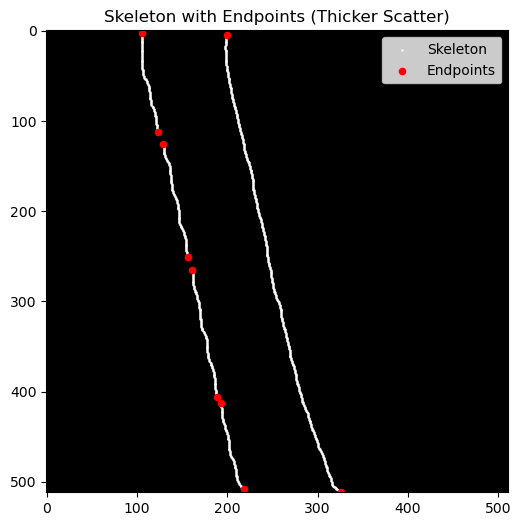

In [37]:
i = 6
pred_mask = np.array(all_preds[i]).squeeze()  # your predicted 2D mask
gt_mask = np.array(all_targets[i]).squeeze()  # your ground truth 2D mask

# 1. Skeletonize
skel_pred = get_skeleton(pred_mask, labeled=False)
skel_gt = get_skeleton(gt_mask, labeled=False)

# 2. Visualize initial skeleton
endpoints_pred = find_endpoints(skel_pred)
visualize_skeleton_and_endpoints(skel_pred, endpoints_pred, skeleton_marker_size=0.5)

In [38]:
# Example toy skeletons (7x7)
gt_skel = np.array([
    [0,0,0,0,0,0,0],
    [0,1,1,1,0,0,0],
    [0,0,0,1,0,0,0],
    [0,0,0,1,0,0,0],
    [0,0,0,1,1,1,0],
    [0,0,0,0,0,0,0],
    [0,0,0,0,0,0,0],
], dtype=np.uint8)

pred_skel = np.array([
    [0,0,0,0,0,0,0],
    [0,1,1,0,0,0,0],
    [0,0,1,1,0,0,0],
    [0,0,0,1,0,0,0],
    [1,0,0,1,1,1,0],
    [1,0,0,0,0,0,0],
    [1,0,0,0,0,0,0],
], dtype=np.uint8)

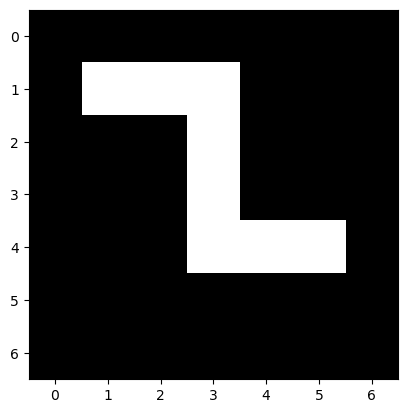

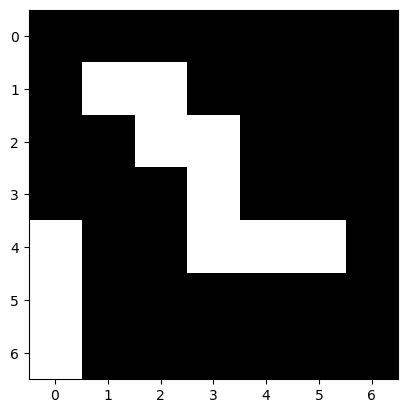

In [39]:

plt.imshow(gt_skel, cmap='gray')
plt.show()

plt.imshow(pred_skel, cmap='gray')
plt.show()

In [40]:

print("Ground-truth skeleton pixel count:", gt_skel.sum())
print("Predicted skeleton pixel count:  ", pred_skel.sum())

# Test with several distance thresholds
for d in [1, 2, 3, 4]:
    tp, fp = count_tp_fp(pred_skel, gt_skel, d)
    print(f"\nDistance threshold: {d}")
    print(f"TP (predicted pixels within d): {tp}")
    print(f"FP (remaining predicted pixels): {fp}")

Ground-truth skeleton pixel count: 8
Predicted skeleton pixel count:   11

Distance threshold: 1
TP (predicted pixels within d): 8
FP (remaining predicted pixels): 3.0

Distance threshold: 2
TP (predicted pixels within d): 8
FP (remaining predicted pixels): 3.0

Distance threshold: 3
TP (predicted pixels within d): 9
FP (remaining predicted pixels): 2.0

Distance threshold: 4
TP (predicted pixels within d): 11
FP (remaining predicted pixels): 0.0
